## News Source Classification

In [ ]:
%%capture
!pip install transformers numpy pandas sentence-transformers datasets

## Import Packages & Load Dataset

In [ ]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CIS5190 Final Project/Final Deliverables/headlines_and_outlet.csv')
df.drop(['error', 'url'], axis=1, inplace=True)
df.head(5)

,headline,outlet
0,Jack Carr recalls Gen. Eisenhower's D-Day memo...,foxnews
1,"Bruce Willis, Demi Moore avoided doing one thi...",foxnews
2,"Blinken meets Qatar PM, says Israeli actions a...",foxnews
3,Emily Blunt says her ‘toes curl’ when people t...,foxnews
4,"'The View' co-host, CNN commentator Ana Navarr...",foxnews


In [ ]:
print(f"Total number of rows in raw dataset: {len(df)}")
print(f"Shape of the raw dataset: {df.shape}")

Total number of rows in raw dataset: 3805
Shape of the raw dataset: (3805, 2)


## Preprocessing Data

### Remove any missing/empty duplicated headlines + drop duplicates
Remove any missing or empty headlines and drop any duplicated headline entries, if any, to reduce bias and ensure clean labels

In [ ]:
# Drop any rows where headline is missing or consists only of whitespace
df.dropna(subset=['headline'], inplace = True)
df = df[df['headline'].str.strip() != '']
df.drop_duplicates(subset=['headline'], inplace=True)

Check how many datapoints we have of each unique label class

In [ ]:
df['outlet'].value_counts()

,count
outlet,
foxnews,2000
nbcnews,1786


## Label Mapping: Source column to binary labels

We map the 'source' column to a binary label:

- 'foxnews' = 1
- 'nbcnews' = 0

This label will be used as the target for our binary classification models going forward.

In [ ]:
df['outlet'] = df['outlet'].map({'foxnews': 1, 'nbcnews': 0})
df.head(5)

,headline,outlet
0,Jack Carr recalls Gen. Eisenhower's D-Day memo...,1
1,"Bruce Willis, Demi Moore avoided doing one thi...",1
2,"Blinken meets Qatar PM, says Israeli actions a...",1
3,Emily Blunt says her ‘toes curl’ when people t...,1
4,"'The View' co-host, CNN commentator Ana Navarr...",1


## Baseline Model (Lexical Model 1) : Logistic Model with TF-IDF Features

In this section, we replicate the baseline model described in the project instructions. We use the raw (minimally cleaned) headlines, convert them into TF-IDF vectors, and train a logistic regression classifier.
This baseline is used to benchmark and compare the effects of improved preprocessing and more advanced models in later sections.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Split the data into training and testing sets (80 training, 20 test)
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df['headline'],
                                                    df['outlet'],
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify = df['outlet'])

# Covert the text data into TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(random_state=seed)
model.fit(X_train_tfidf, y_train)

# Make prediction on test set
y_pred = model.predict(X_test_tfidf)

# Evaluate model on metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6926
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       358
           1       0.68      0.79      0.73       400

    accuracy                           0.69       758
   macro avg       0.70      0.69      0.69       758
weighted avg       0.69      0.69      0.69       758



## Text Cleaning: Normalize and Prepare Headlines

We apply deeper preprocessing to clean the headline texts. This includes:
- Lowercasing
- Removing punctuation, numbers, and symbols
- Removing English stopwords
- Lemmatizing words to their base form

This additional preprocessing of headlines will be used to retrain the baseline TF-IDF + logisitic regression model to evaluate whether or not our preprocessing is beneficial for more advanced models.

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create function for all additional cleaning features
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df['cleaned_headline'] = df['headline'].apply(clean_text)
df.head(5)

,headline,outlet,cleaned_headline
0,Jack Carr recalls Gen. Eisenhower's D-Day memo...,1,jack carr recall gen eisenhower dday memo grea...
1,"Bruce Willis, Demi Moore avoided doing one thi...",1,bruce willis demi moore avoided one thing copa...
2,"Blinken meets Qatar PM, says Israeli actions a...",1,blinken meet qatar pm say israeli action retal...
3,Emily Blunt says her ‘toes curl’ when people t...,1,emily blunt say toe curl people tell kid want ...
4,"'The View' co-host, CNN commentator Ana Navarr...",1,view cohost cnn commentator ana navarro host n...


## Retrained Baseline: Deeper Cleaned Headlines + TD-IDF + Logistic Regression

In this code, we are using the same TF-IDF vectorizer and logistic regression model but are retraining it on the deeper cleaned preprocessed data. That way, we can isolate the impact of preprocessing improvements while keeping all other modeling factors constant.

In [ ]:
seed = 42

# Set up train test split (80/20)
Xclean_train, Xclean_test, yclean_train, yclean_test = train_test_split(df['cleaned_headline'],
                                                    df['outlet'],
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify = df['outlet'])

# TF-IDF vectorization on cleaned text
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
Xclean_train_tfidf = vectorizer.fit_transform(Xclean_train)
Xclean_test_tfidf = vectorizer.transform(Xclean_test)

# Train logistic regression
model = LogisticRegression(random_state=seed)
model.fit(Xclean_train_tfidf, yclean_train)

# Make prediction on test set
yclean_pred = model.predict(Xclean_test_tfidf)

# Evaluate model on performance metrics
acc = accuracy_score(yclean_test, yclean_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(yclean_test, yclean_pred))

Accuracy: 0.6992
              precision    recall  f1-score   support

           0       0.73      0.58      0.64       358
           1       0.68      0.81      0.74       400

    accuracy                           0.70       758
   macro avg       0.71      0.69      0.69       758
weighted avg       0.70      0.70      0.69       758



## Perform baseline tests on cleaned data for Lexical vs Semantic focused models

Using consistent preprocessing techniques and input structure, we compare classic lexical models with modern semantic models. This allows us to isolate the impact of text representation on classifier performance.

## Lexical Model 2: TF-IDF + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

seed = 42
# Train Random forest
rf = RandomForestClassifier(random_state=seed)
rf.fit(Xclean_train_tfidf, yclean_train)

# Make predictions on test set
yrf_pred = rf.predict(Xclean_test_tfidf)

# Evaluate model on performance metrics
acc = accuracy_score(yclean_test, yrf_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(yclean_test, yrf_pred))

Accuracy: 0.6821
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       358
           1       0.68      0.76      0.72       400

    accuracy                           0.68       758
   macro avg       0.68      0.68      0.68       758
weighted avg       0.68      0.68      0.68       758



## Lexical Model 3: TF-IDF + XGBoost

In [ ]:
from xgboost import XGBClassifier

seed = 42

# Train XGBoost
xgb = XGBClassifier(random_state=seed)
xgb.fit(Xclean_train_tfidf, yclean_train)

# Make predictions on test set
yxgb_pred = xgb.predict(Xclean_test_tfidf)

# Evaluate model on performance metrics
acc = accuracy_score(yclean_test, yxgb_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(yclean_test, yxgb_pred))

Accuracy: 0.6887
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       358
           1       0.67      0.80      0.73       400

    accuracy                           0.69       758
   macro avg       0.69      0.68      0.68       758
weighted avg       0.69      0.69      0.68       758



## Lexical Model 4: TF-IDF + Support Vector Machine

In [ ]:
from sklearn.svm import SVC

seed = 42

# Train SVM
svm = SVC(random_state=seed)
svm.fit(Xclean_train_tfidf, yclean_train)

# Make predictions on test set
ysvm_pred = svm.predict(Xclean_test_tfidf)

# Evaluate model on performance metrics
acc = accuracy_score(yclean_test, ysvm_pred)
print(f"Accuracy: {acc:.4f}")
print(classification_report(yclean_test, ysvm_pred))

Accuracy: 0.6887
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       358
           1       0.67      0.80      0.73       400

    accuracy                           0.69       758
   macro avg       0.69      0.68      0.68       758
weighted avg       0.69      0.69      0.68       758



## Generate Sentence Embeddings (SBERT 'all-MiniLM-L6-v2')

To generate contextual semantic representations, we use Sentence-BERT, a transformer-based sentence embedding model designed for sentence-level tasks. Unlike Word2Vec, averages static word vectors in this application, SBERT captures the full contextual meaning of a sentence using transformer attention mechanisms. We use 'all-MiniLM-L6-v2' pre-trained model from sentence-transformers in HuggingFace to embed each headline into a 384-dimensional dense vector to preserve the underlying semantic content and tone of each sentence, making it more suitable for understanding short texts like headlines.

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
Xclean_train_sbert = model.encode(Xclean_train.tolist(), show_progress_bar=True)
Xclean_test_sbert = model.encode(Xclean_test.tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

## Semantic Model 1: Sentence-BERT + Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression
model = LogisticRegression()
model.fit(Xclean_train_sbert, yclean_train)

# Make predictions
yclean_pred = model.predict(Xclean_test_sbert)

# Evaluate model on compute metrics
acc = accuracy_score(yclean_test, yclean_pred)
print(f'Accuracy: {acc:.4f}')
print(classification_report(yclean_test, yclean_pred))

Accuracy: 0.6939
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       358
           1       0.71      0.70      0.71       400

    accuracy                           0.69       758
   macro avg       0.69      0.69      0.69       758
weighted avg       0.69      0.69      0.69       758



## Semantic Model 2: Sentence-BERT + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train random forest
model = RandomForestClassifier(random_state=seed)
model.fit(Xclean_train_sbert, yclean_train)

# Make predictions
yclean_pred = model.predict(Xclean_test_sbert)

# Evaluate model on compute metrics
acc = accuracy_score(yclean_test, yclean_pred)
print(f'Accuracy: {acc:.4f}')
print(classification_report(yclean_test, yclean_pred))

Accuracy: 0.7309
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       358
           1       0.73      0.79      0.75       400

    accuracy                           0.73       758
   macro avg       0.73      0.73      0.73       758
weighted avg       0.73      0.73      0.73       758



## Semantic Model 3: Sentence-BERT + XGBoost

In [ ]:
from xgboost import XGBClassifier

# Train XGBoost
model = XGBClassifier(random_state=seed)
model.fit(Xclean_train_sbert, yclean_train)

# Make predictions
yclean_pred = model.predict(Xclean_test_sbert)

# Evaluate model on compute metrics
acc = accuracy_score(yclean_test, yclean_pred)
print(f'Accuracy: {acc:.4f}')
print(classification_report(yclean_test, yclean_pred))

Accuracy: 0.7507
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       358
           1       0.76      0.77      0.76       400

    accuracy                           0.75       758
   macro avg       0.75      0.75      0.75       758
weighted avg       0.75      0.75      0.75       758



## Semantic Model 4: Sentence-BERT + Support Vector Machine

In [ ]:
from sklearn.svm import SVC

seed = 42

# Train SVM
model = SVC(random_state=seed)
model.fit(Xclean_train_sbert, yclean_train)

# Make predictions
yclean_pred = model.predict(Xclean_test_sbert)

# Evaluate model on compute metrics
acc = accuracy_score(yclean_test, yclean_pred)
print(f'Accuracy: {acc:.4f}')
print(classification_report(yclean_test, yclean_pred))

Accuracy: 0.7652
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       358
           1       0.76      0.81      0.78       400

    accuracy                           0.77       758
   macro avg       0.77      0.76      0.76       758
weighted avg       0.77      0.77      0.76       758



## Summary Comparison (Lexical vs. Semantic Embeddings)

The heatmap below compares the model accuracy tested across different representation strategies. We evaluate two different embedding types: TF-IDF (lexical) and SBERT (contextual semantic) with multiple different classifiers. This summary allows us to assess whether semantic sentence embeddings consistently outperform traditional lexical approaches in the task of classifying news headlines by source.

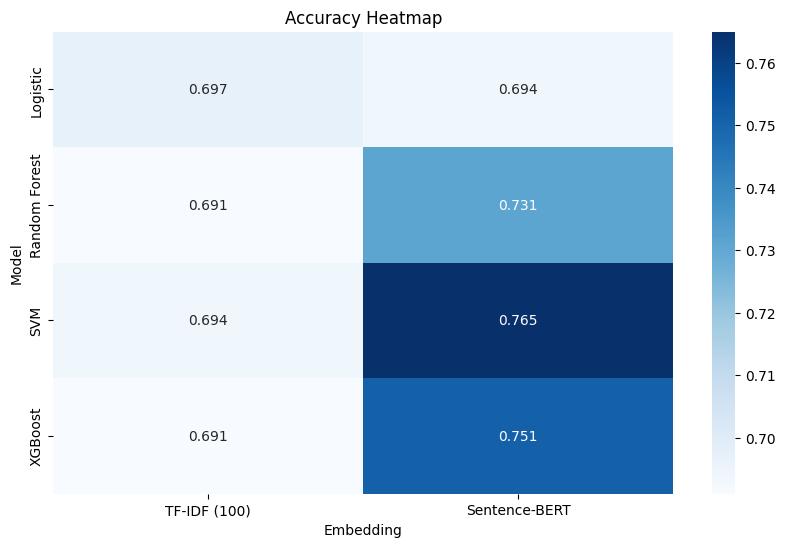

In [ ]:
# Dataframe with baseline results of lexical and semantic models
results = pd.DataFrame([
    {'Model': 'Logistic', 'Embedding': 'TF-IDF (100)', 'Accuracy': 0.697},
    {'Model': 'Random Forest', 'Embedding': 'TF-IDF (100)', 'Accuracy': 0.691},
    {'Model': 'XGBoost', 'Embedding': 'TF-IDF (100)', 'Accuracy': 0.691},
    {'Model': 'SVM', 'Embedding': 'TF-IDF (100)', 'Accuracy': 0.694},
    {'Model': 'Logistic', 'Embedding': 'Sentence-BERT', 'Accuracy': 0.694},
    {'Model': 'Random Forest', 'Embedding': 'Sentence-BERT', 'Accuracy': 0.731},
    {'Model': 'XGBoost', 'Embedding': 'Sentence-BERT', 'Accuracy': 0.751},
    {'Model': 'SVM', 'Embedding': 'Sentence-BERT', 'Accuracy': 0.765}
])

order = ['TF-IDF (100)', 'Sentence-BERT']
hm_df = results.pivot(index='Model', columns='Embedding', values='Accuracy')

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(hm_df.reindex(columns=order),
            annot=True,
            cmap='Blues',
            fmt='.3f')
plt.title('Accuracy Heatmap')
plt.ylabel('Model')
plt.xlabel('Embedding')
plt.show()

### Observations from our Baseline Model Comparison:

Our initial baseline comparison of lexical and semantic models reveals several key highlights:

- Sentence-BERT paired with SVM or XGBoost achieves the highest accuracy, indicating that strong semantic understanding of short headline texts.
- TF-IDF with 100 features while fast and interpretable, slightly underperforms, giving us accuracies in the ~69% range depending on the classifier.
- Word2Vec embeddings paired with SVM suprisingly perform competitively, but given its shallower semantic capabilities and lack of contextual understanding, it is not going to be the focus of our primary motivation

These results suggest that semantic models have the potential to outperform lexical ones, but the gap of accuracy is not wide enough to definitely conclude that it is the case. To further test this hypothesis, we need to explore two extended experiments:

1. Increasing the feature space of TF-IDF to see if lexical models are being bottlenecked by vocabulary limits
2. Fine-Tuning BERT end-to-end to create task-specific sentence encoder that may be better to capture political term, bias, and entity framing.

## Experimental Consistency: Classifier controls

To ensure our analysis remains fair and interpretable, we apply the same four classifiers across all representatio types, including both lexical and semantic models. This helps isolate the influence of the text represention itself from the classifier architecture.

We apply this to both extended experiments:
- Lexical extension by increasing TF-IDF feature space.
- Semantic extension via end-to-end fine-tuned BERT on our dataset.

## Extension 1: Increased TF-IDF 'max_features' (Vocabulary Size)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

seed = 42
max_feats = [1000, 2500, 5000]

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=seed),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed),
    'SVM': SVC(random_state=seed)
}

for max_feat in max_feats:
  print(f"\n---------- TF-IDF max_features = {max_feat} ----------")
  tfidf = TfidfVectorizer(stop_words = 'english', max_features=max_feat)
  X_train_tfidf = tfidf.fit_transform(Xclean_train)
  X_test_tfidf = tfidf.transform(Xclean_test)
  for model, clf in classifiers.items():
    print(f"\n{model} (TF-IDF {max_feat})")
    clf.fit(X_train_tfidf, yclean_train)
    y_pred = clf.predict(X_test_tfidf)
    acc = accuracy_score(yclean_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(yclean_test, y_pred))


---------- TF-IDF max_features = 1000 ----------

Logistic Regression (TF-IDF 1000)
Accuracy: 0.7784
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       358
           1       0.76      0.85      0.80       400

    accuracy                           0.78       758
   macro avg       0.78      0.77      0.78       758
weighted avg       0.78      0.78      0.78       758


Random Forest (TF-IDF 1000)
Accuracy: 0.7507
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       358
           1       0.74      0.80      0.77       400

    accuracy                           0.75       758
   macro avg       0.75      0.75      0.75       758
weighted avg       0.75      0.75      0.75       758


XGBoost (TF-IDF 1000)
Accuracy: 0.7546
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       358
           1       0.74      0.83      0.78      

## Summary Table and Heatmap: TF-IDF Performance by Feature Size and Classifier

We summarize the accuracy results of all four classifiers across three different TF-IDF vocabulary sizes: 1000, 2500, 5000. The heatmap below represents a visual comaprision across various configurations. This gives us a clear understanding of how TF-IDF feature size impacts model performance and sets a solid lexical benchmark before moving on to semantic fine-tuning with BERT.

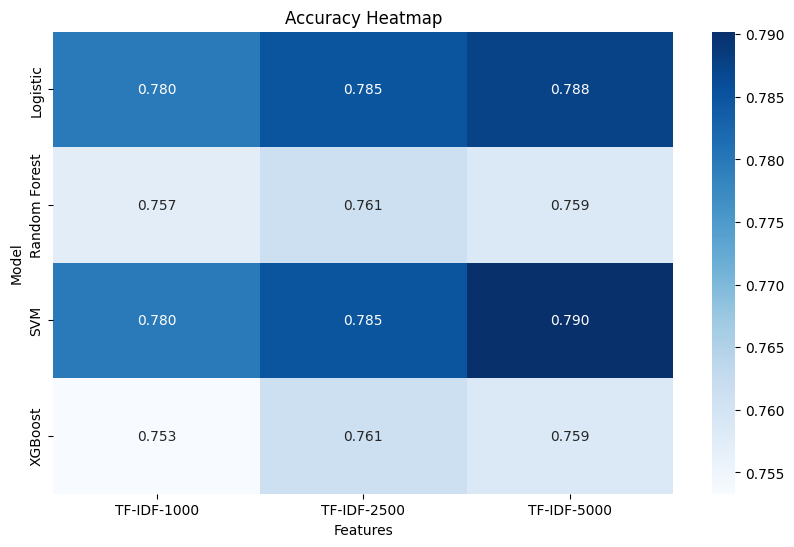

In [ ]:
tfidf_results = pd.DataFrame([
    {"Embedding": "TF-IDF", "Features": 1000, "Model": "Logistic", "Accuracy": 0.7797},
    {"Embedding": "TF-IDF", "Features": 1000, "Model": "Random Forest", "Accuracy": 0.7573},
    {"Embedding": "TF-IDF", "Features": 1000, "Model": "XGBoost", "Accuracy": 0.7533},
    {"Embedding": "TF-IDF", "Features": 1000, "Model": "SVM", "Accuracy": 0.7797},

    {"Embedding": "TF-IDF", "Features": 2500, "Model": "Logistic", "Accuracy": 0.7850},
    {"Embedding": "TF-IDF", "Features": 2500, "Model": "Random Forest", "Accuracy": 0.7612},
    {"Embedding": "TF-IDF", "Features": 2500, "Model": "XGBoost", "Accuracy": 0.7612},
    {"Embedding": "TF-IDF", "Features": 2500, "Model": "SVM", "Accuracy": 0.7850},

    {"Embedding": "TF-IDF", "Features": 5000, "Model": "Logistic", "Accuracy": 0.7876},
    {"Embedding": "TF-IDF", "Features": 5000, "Model": "Random Forest", "Accuracy": 0.7586},
    {"Embedding": "TF-IDF", "Features": 5000, "Model": "XGBoost", "Accuracy": 0.7586},
    {"Embedding": "TF-IDF", "Features": 5000, "Model": "SVM", "Accuracy": 0.7902},
])

tm_df = tfidf_results.pivot(index='Model', columns=['Embedding', 'Features'], values='Accuracy')

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tm_df,
            annot=True,
            cmap='Blues',
            fmt='.3f')
plt.title('Accuracy Heatmap')
plt.ylabel('Model')
plt.xlabel('Features')
plt.show()


## Insights from TF-IDF Performance Comparision

- SVM and Logisitic Regression consistently outperform RF and XGBoost across all feature sizes. This aligns with expectations, as linear models tend to outperform non-linear models with sparse, high-dimensional TF-IDF data.
- Performance improves as TF-IDF feature size increases, with SVM acheiving highest accuracy at 5000 features with an overall score of 79%.
- Tree based models plateau at around ~76% accuracy, showing limited agains in TF-IDF method due to their inefficiency with sparse feature spaces.


Results confirm that lexical representations, when properly tuned, are highly competitive. It sets a strong baseline as we transition to Extension 2, where we fine-tune BERT for task-specific sentence-level understanding.

## Extension 2:

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)
print("using device:", device)

# Initialize dataset to be compatiable with HuggingFace
df_train = pd.DataFrame({'headline': Xclean_train.tolist(), 'label': yclean_train.tolist()})
df_test = pd.DataFrame({'headline': Xclean_test.tolist(), 'label': yclean_test.tolist()})
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

# Set tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["headline"], padding="max_length", truncation=True)

tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

if torch.cuda.is_available():
    tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

using device: cuda


Map:   0%|          | 0/3028 [00:00<?, ? examples/s]

Map:   0%|          | 0/758 [00:00<?, ? examples/s]

In [ ]:
# Load pre-trained DistilBERT model"
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

# Define training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.536000,0.552829,0.725594
2,0.529000,0.496624,0.762533
3,0.339000,0.507454,0.758575
4,0.260400,0.519877,0.766491
5,0.346200,0.518147,0.770449


TrainOutput(global_step=950, training_loss=0.4103703385905216, metrics={'train_runtime': 835.0779, 'train_samples_per_second': 18.13, 'train_steps_per_second': 1.138, 'total_flos': 2005556415651840.0, 'train_loss': 0.4103703385905216, 'epoch': 5.0})

In [ ]:
print(trainer.state.best_model_checkpoint)

./results/checkpoint-950


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("/content/results/checkpoint-2850")
model = model.to(device)

def get_cls_embeddings(texts, batch_size=32):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model.distilbert(**inputs)
            cls_embed = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embed.cpu().numpy())
    return np.vstack(embeddings)

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=seed),
    'Random Forest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(random_state=seed),
    'SVM': SVC(random_state=seed)
}

df_contextual_train = pd.DataFrame({'headline': Xclean_train.tolist(), 'label': yclean_train.tolist()})
df_contextual_test = pd.DataFrame({'headline': Xclean_test.tolist(), 'label': yclean_test.tolist()})

X_train_contextual = get_cls_embeddings(df_contextual_train['headline'].tolist())
X_test_contextual = get_cls_embeddings(df_contextual_test['headline'].tolist())

for model, clf in classifiers.items():
    print(f"\n{model} (Contextual)")
    clf.fit(X_train_contextual, df_contextual_train['label'])
    y_pred = clf.predict(X_test_contextual)
    acc = accuracy_score(df_contextual_test['label'], y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(df_contextual_test['label'], y_pred))


Logistic Regression (Contextual)
Accuracy: 0.8232
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       358
           1       0.82      0.85      0.84       400

    accuracy                           0.82       758
   macro avg       0.82      0.82      0.82       758
weighted avg       0.82      0.82      0.82       758


Random Forest (Contextual)
Accuracy: 0.8219
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       358
           1       0.82      0.85      0.83       400

    accuracy                           0.82       758
   macro avg       0.82      0.82      0.82       758
weighted avg       0.82      0.82      0.82       758


XGBoost (Contextual)
Accuracy: 0.8219
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       358
           1       0.84      0.82      0.83       400

    accuracy                           0.82    